In [5]:
%matplotlib inline

In [1]:
import numpy as np
import cv2
import pyrealsense2 as rs
import matplotlib.pyplot as plt
from fistwriter.process import spaces
import h5py

/Users/tom/Documents/multi-touch/pre-existed/fistwriter/process/spaces.py:14: UserWarning: PCL not available.
  warnings.warn("PCL not available.")


In [2]:
import pyrs12

In [3]:
cam = pyrs12.Camera()

In [4]:
cam.start()

In [5]:
cam.wait_for_frames()

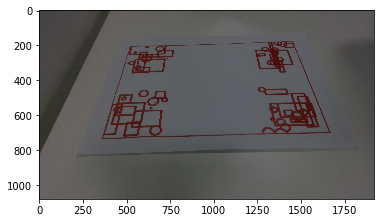

In [95]:
plt.imshow(cam.color)

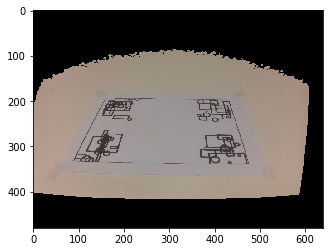

In [6]:
plt.imshow(cam.cad)

In [14]:
scene = spaces.Scene(cam, './rgb-marker.png')

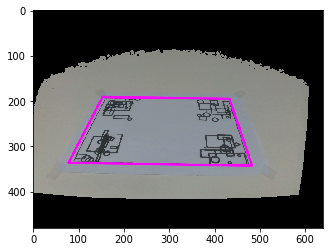

In [15]:
plt.imshow(scene.draw_surface(cam.cad))

In [18]:
cam.stop()

RuntimeError: stop() cannot be called before start()

In [17]:
org = scene.system.pcl_center
mat = scene.system.trans_matrix
print(org)
print(mat)

[-0.02303206  0.00553709  0.36346117]
[[-0.999935   -0.01140039  0.        ]
 [-0.01181234  0.6226229  -0.78243285]
 [ 0.01131346 -1.245265   -1.        ]]


In [106]:
def normalize(mat, org):
    cam = pyrs12.Camera()
    cam.start()
    for i in range(10):
        cam.wait_for_frames()
    point = np.dot(mat, (cam.pointcloud - org).reshape((-1,3)).T).T
    cam.stop()
    v = pptk.viewer(point)

In [109]:
normalize(mat, org)

## Read file

In [8]:
!ls ../recording_data

Vhdf5_20181111_183528.hdf5 backup
Vhdf5_20181111_183602.hdf5


In [9]:
data = h5py.File('../recording_data/Vhdf5_20181111_183602.hdf5', 'r')

In [10]:
data['depth']

<HDF5 dataset "depth": shape (120, 480, 640), type "<i2">

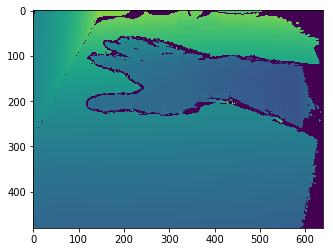

In [11]:
plt.imshow(data['depth'][50])

In [12]:
%load_ext cython

In [13]:
%%cython
import numpy as np
cimport numpy as np
import pyrealsense2 as rs

DTYPE = np.float32
ctypedef np.float32_t DTYPE_t

def deproject_depth_cy(short[:,:]depth_image, intr, double depth_scale):
    
    cdef int height = intr.height
    cdef int width  = intr.width
    cdef int dx, dy
    cdef float depth_value
    
    cdef np.ndarray[DTYPE_t, ndim=3] pointcloud = np.zeros((height, width, 3), dtype=np.float32)
    
    cdef res = []
    cdef np.ndarray[DTYPE_t, ndim=1] point = np.zeros(3, dtype=np.float32)
    
    cdef float x,y, r2, f, ux, uy
    cdef float ppx, ppy, fx, fy, c0, c1, c2, c3, c4
    
    ppx = intr.ppx
    ppy = intr.ppy
    fx  = intr.fx
    fy  = intr.fy
    c0  = intr.coeffs[0]
    c1  = intr.coeffs[1]
    c2  = intr.coeffs[2]
    c3  = intr.coeffs[3]
    c4  = intr.coeffs[4]
    
    for dy in range(height):
        for dx in range(width):
            depth_value = depth_image[dy, dx] * depth_scale
            if depth_value == 0: continue

            x = (dx - ppx) / fx;
            y = (dy - ppy) / fy;
            r2  = x*x + y*y;
            f = 1 + c0*r2 + c1*r2*r2 + c4*r2*r2*r2;
            ux = x*f + 2*c2*x*y + c3*(r2 + 2*x*x);
            uy = y*f + 2*c3*x*y + c2*(r2 + 2*y*y);
            
            x = ux;
            y = uy;
#             point[0] = depth_value * x;
#             point[1] = depth_value * y;
#             point[2] = depth_value;
#             for i in range(3):
#                 pointcloud[dy, dx, i] = point[i]
            
            pointcloud[dy, dx, 0] = depth_value * x;
            pointcloud[dy, dx, 1] = depth_value * y;
            pointcloud[dy, dx, 2] = depth_value;

    
    return pointcloud

In [14]:
import yaml
with open('sr300_610205001689.param', 'r') as fh:
    d = yaml.load(fh)
intr_ = d['610205001689']
intr = rs.intrinsics()
intr.coeffs = intr_['coeffs']
intr.width  = intr_['width']
intr.height = intr_['height']
intr.ppx    = intr_['ppx']
intr.ppy    = intr_['ppy']
intr.fx     = intr_['fx']
intr.fy     = intr_['fy']
# intr.model  = intr_['model']
intr.coeffs = intr_['coeffs']

ds = intr_['depth_scale']

In [29]:
pc_cy = np.asanyarray(deproject_depth_cy(data['depth'][50], intr, ds))

In [30]:
print(pc_cy[0,0])

[0. 0. 0.]


In [31]:
import pptk

In [32]:
import pandas as pd
from pyntcloud import PyntCloud
def uPyntCloud(point):
    p = point.reshape(-1,3)
    df = pd.DataFrame(p)
    p=None
    df =df.rename(index=str, columns={0: "x", 1: "y", 2: "z"})
    cloud = PyntCloud(df)
    cloud.plot()

In [33]:
#uPyntCloud(pc_cy)
v = pptk.viewer(pc_cy)

In [34]:
pc_cy.shape

(480, 640, 3)

In [35]:
pc_cy.reshape((-1,3)).shape

(307200, 3)

In [36]:
pc_cy.reshape((-1,3)).reshape((480, 640, 3)).shape

(480, 640, 3)

In [37]:
np.array_equal(pc_cy.reshape((-1,3)).reshape((480, 640, 3)), pc_cy)

True

In [38]:
org = data['pcl_center'][...]
mat = data['trans_matrix'][...]
X=pc_cy
point = np.dot(mat, (X - org).reshape((-1,3)).T).T.reshape((480, 640, 3))

In [39]:
print(org)
print(mat)

[-0.01647176 -0.04159423  0.32471532]
[[ 9.9973458e-01 -2.0690957e-02 -1.0132543e-02]
 [ 6.3878769e-04 -7.7417898e-01  6.3296640e-01]
 [-1.8815961e-02 -6.3154346e-01 -7.7511215e-01]]


In [40]:
v = pptk.viewer(point)
#uPyntCloud(point)

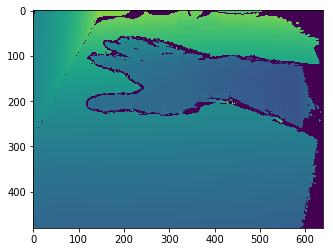

In [41]:
plt.imshow(data['depth'][50])

# idea
The point cloud generated by cython is the same shape as the original image, so maybe image filter also work on point cloud?

In [42]:
pc_cy.shape

(480, 640, 3)

In [43]:
data['color'][50].shape

(480, 640, 3)

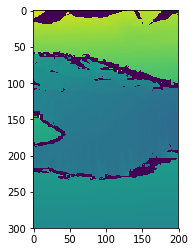

In [44]:
plt.imshow(data['depth'][50][:300,200:400])

In [47]:
v = pptk.viewer(pc_cy[:300,200:400])

In [48]:
v = pptk.viewer(point[:300,200:400])